In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

#import math #計算combinations
import random #做隨機抽樣分布

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm

In [2]:
healthy = sc.read_h5ad("GSE174188/GSE174188_Healthy.h5ad")
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'cg_cov_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [3]:
cell_type = list(set(healthy.obs.cg_cov))
cell_type

['NK', 'ncM', 'cDC', 'PB', 'Progen', 'Prolif', 'T4', 'pDC', 'B', 'cM', 'T8']

In [4]:
sample = list(set(healthy.obs.ind_cov))

personal = {}
for i in sample:
    if i not in personal:
        personal[i] = healthy[healthy.obs.ind_cov == i, :]        
# 將personal進行排序
sorted_personal = dict(sorted(personal.items(), key=lambda x: x[1].obs.Age[0]))


# 排序之後取得年齡
age = []
for i in sorted_personal:
    age.append(sorted_personal[i].obs.Age[0])

# Proportion

## total(人)/total(all)

Text(0.5, 1.0, 'Cells proportion in each person')

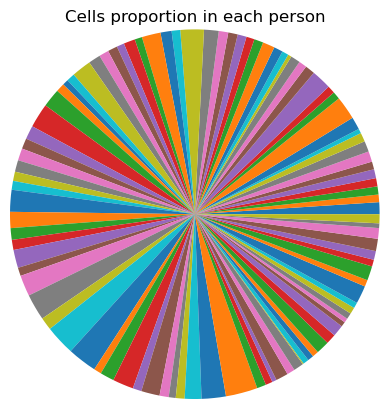

In [5]:
total_cell = 0
person_proportion = []
ID = []
total_cell = healthy.n_obs

for i in sorted_personal:
    total_person_cell = sorted_personal[i].n_obs / total_cell
    ID.append(i)
    person_proportion.append(round(total_person_cell*100,2))
    #print(f"Total(人):{sorted_personal[i].n_obs}\t person Proportion:{round(total_person_cell*100,2)}%")
    
plt.pie(person_proportion, radius = 1.25)
# displaying the title
plt.title("Cells proportion in each person")


## cell type(人)/total(人)

個人所有的細胞 分之 各種cell type

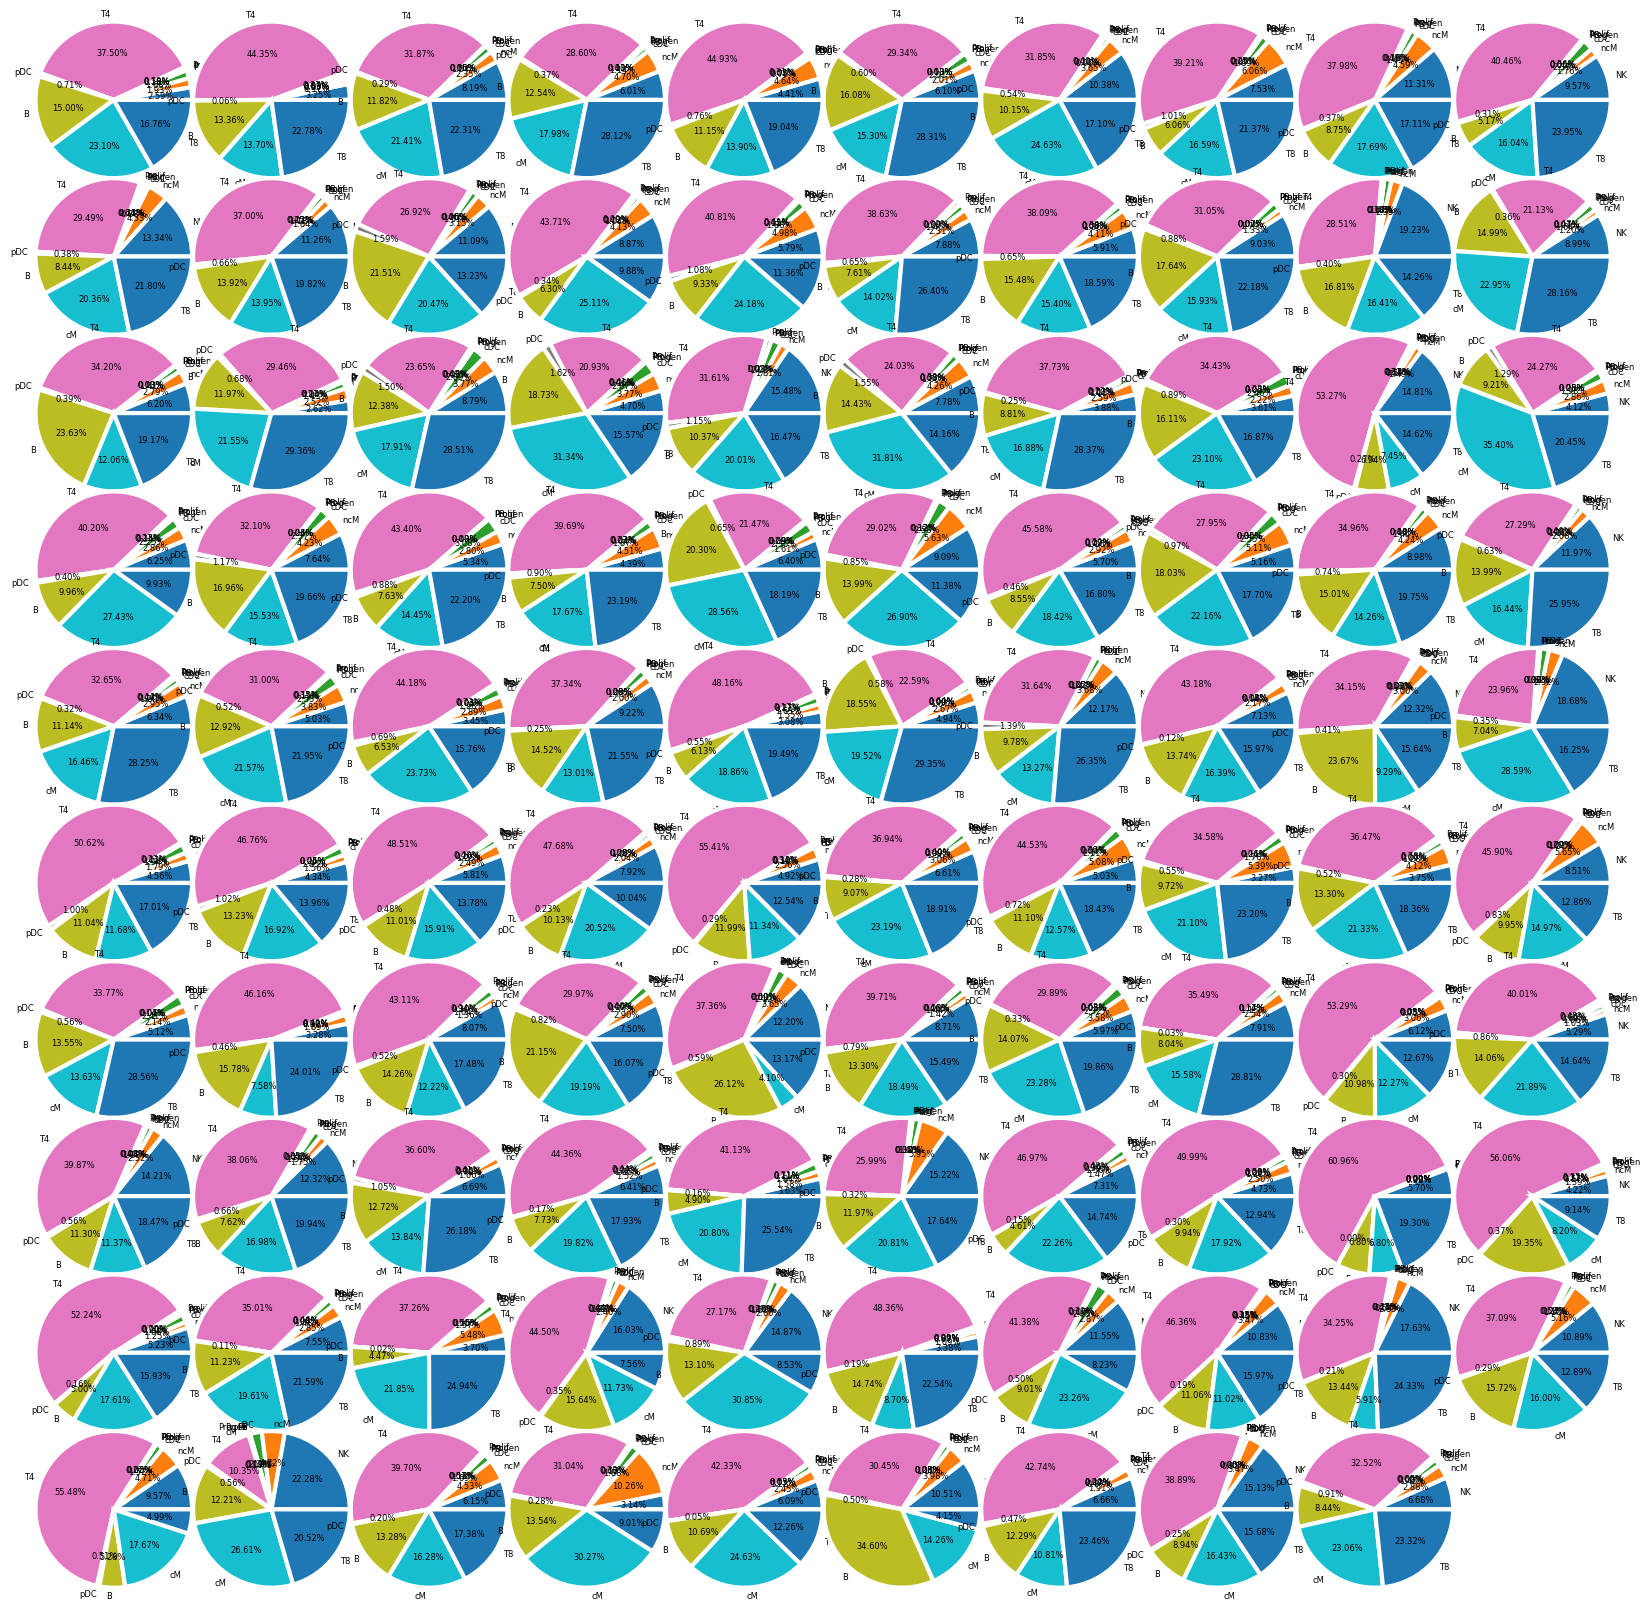

In [6]:
# 創建一個10x10的子圖陣列
fig, axs = plt.subplots(10, 10, figsize=(20,20))

total_personal = []
for i in sorted_personal: # 99人
    person = []
    for j in cell_type: # 11種
        a = sorted_personal[i][sorted_personal[i].obs.cg_cov == j,:].n_obs / sorted_personal[i].n_obs
        person.append(round(a*100, 2))
        #print(f"{i}的{j}佔個人cell type : {round(a*100,2)}%")
    total_personal.append(person)

#畫圖
for i in range(len(total_personal)):
    ax = axs[i//10, i%10]  # 選擇子圖
    ax.pie(total_personal[i], radius = 1.5, labels = cell_type, autopct='%.2f%%', textprops={'size':6}, wedgeprops={'linewidth':3,'edgecolor':'w'})
    
# 刪除最後一格空的位置
plt.delaxes(axs[9, 9])
plt.show()

## cell type(人)/cell type(total)

In [7]:
pie_celltype = {}
for i in cell_type:
    # cell type total
    a = healthy[healthy.obs.cg_cov == i, :]
    pie_celltype[i] = []
    # cell type 
    for j in sorted_personal:
        # cell type by personal
        b = sorted_personal[j][sorted_personal[j].obs.cg_cov == i, :]
        # calculate proportion 
        c = b.n_obs / a.n_obs        
        # 放入這個cell type不同人的比例
        pie_celltype[i].append(round(c*100, 2))        
        #print(f"{j} 的 {i} 佔所有 {i} : {round(c*100, 2)}%")

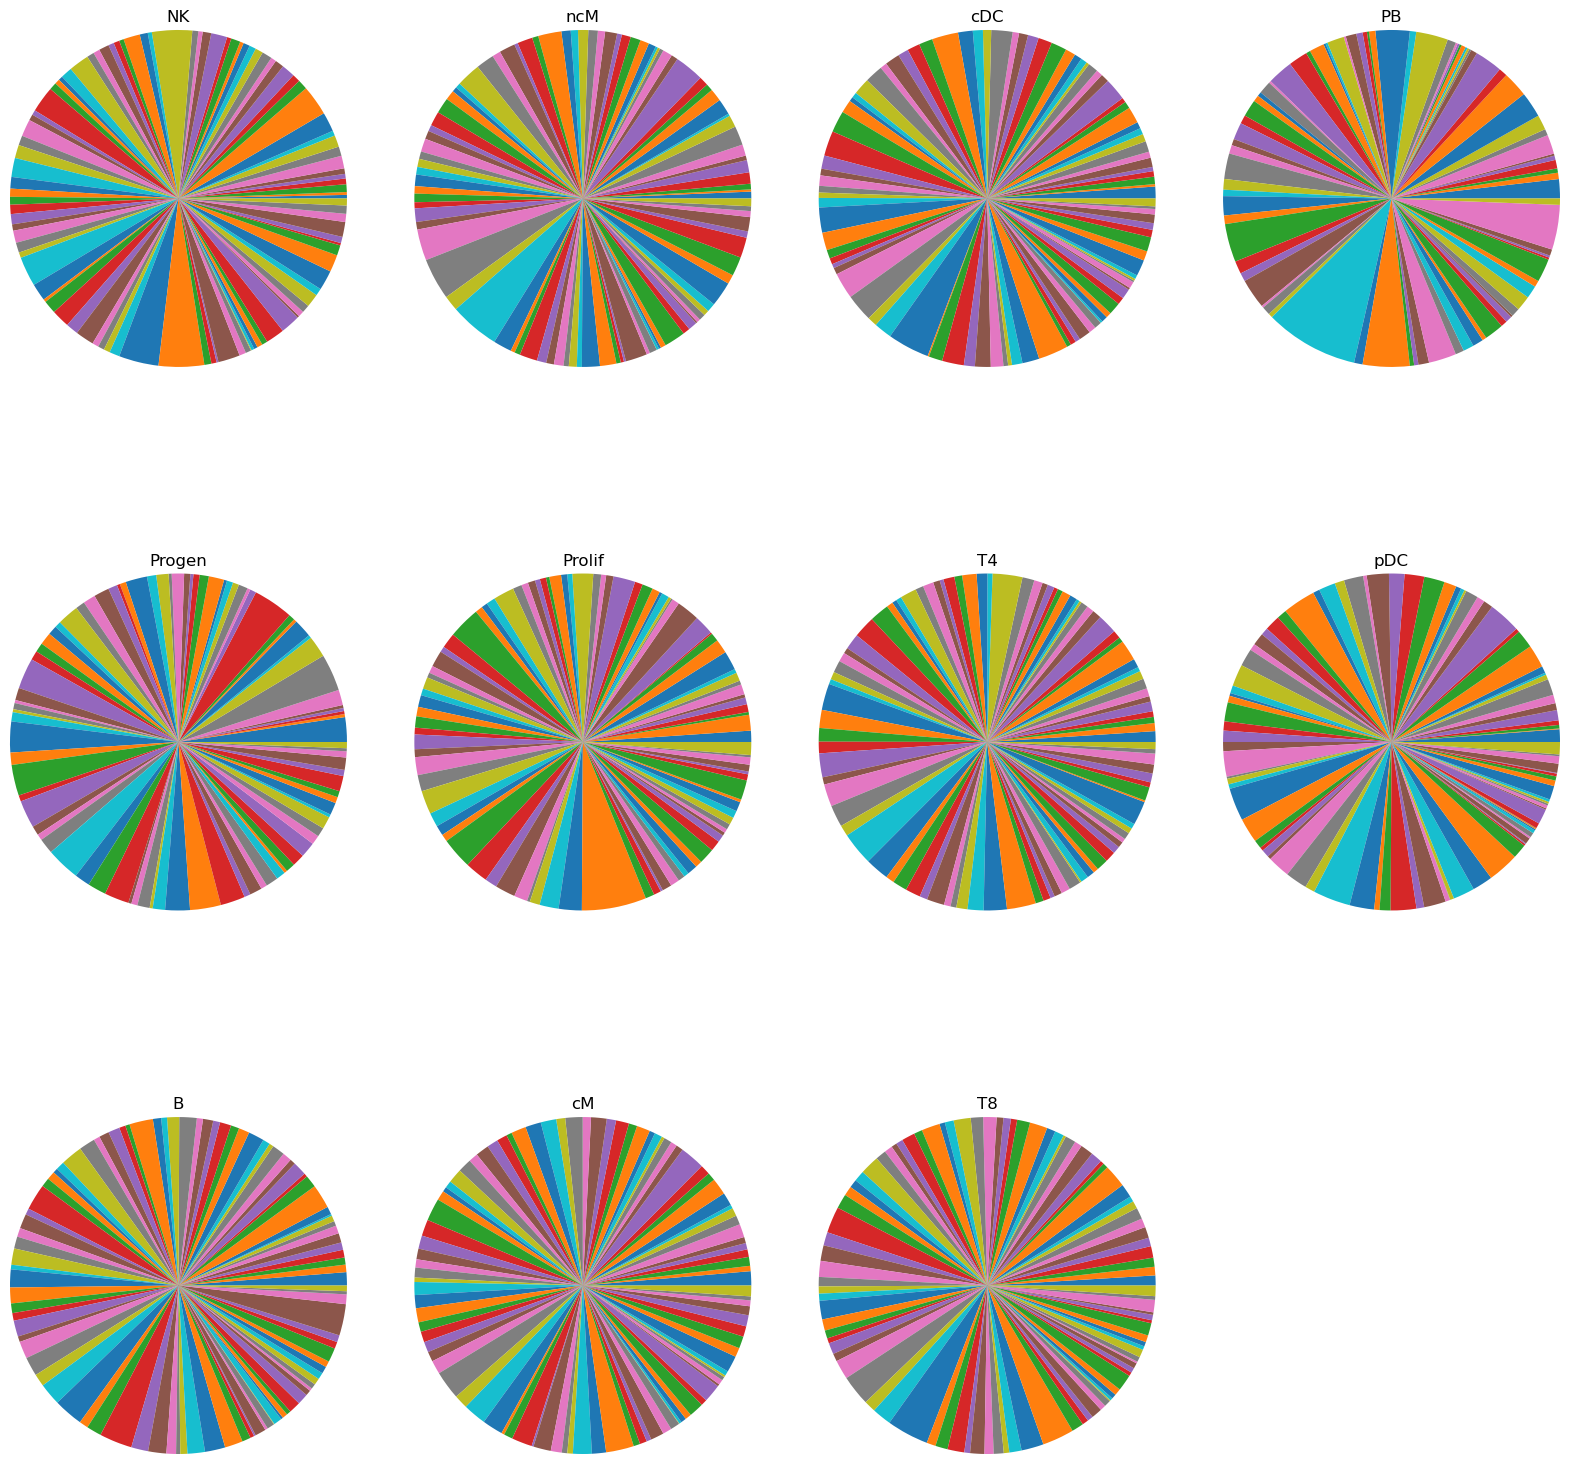

In [8]:
# 創建一個10x10的子圖陣列
fig, axs = plt.subplots(3, 4, figsize=(20,20))
#畫圖
count = 0
for i in pie_celltype:
    ax = axs[count//4, count%4]  # 選擇子圖
    ax.pie(pie_celltype[i], radius = 1.25) # autopct='%.2f%%', textprops={'size':6}
    ax.set_title(i)  # 添加標題
    
    count += 1
    
# 刪除最後一格空的位置
plt.delaxes(axs[2, 3])
plt.show()

# Spearman Correlation

In [9]:
from scipy.stats import spearmanr

def spearman_correlation(adata, cell):
    corr = []
    pvalue = []
    # extract cell type
    cell_type = adata[adata.obs.cg_cov == cell,:]
    # get age and turn into float
    age_float = [float(i) for i in cell_type.obs.Age]
    for gene in cell_type.X.T: # cell_type.X.T才會是基因
        spearman_corr, p_value = spearmanr(age_float, gene)
        corr.append(spearman_corr)
        pvalue.append(p_value)
    
    return corr, pvalue

In [10]:
# ['NK', 'Prolif', 'cDC', 'T8', 'ncM', 'T4', 'cM', 'B', 'PB', 'pDC', 'Progen']
spearman = {}
for i in cell_type:
    corr, pvalue = spearman_correlation(healthy, i)
    spearman[i] = {"corr" : corr, "pvalue" : pvalue}# Pearson Correlation

In [11]:
spearman

{'NK': {'corr': [0.18404800569929972,
   0.14965035677060284,
   0.059416524285588045,
   -0.12100121424908312,
   0.1455182400807623,
   0.1530001280323925,
   0.20552099841503663,
   -0.07396100596353673,
   0.007245414894421507,
   0.28772829148696233,
   0.30617681364128374,
   0.09122793394661136,
   0.07073256057108991,
   0.17100073439117383,
   0.27632145928871404,
   0.17742581586508657,
   0.20118998708265382,
   0.0858489799037045,
   -0.2623817820609348,
   0.30149107675901493,
   0.205836408259456,
   0.25670063160787787,
   0.1155692217999695,
   0.247240175389841,
   0.22966650609282513,
   0.20028214071721606,
   0.2581630953384423,
   0.18839946434565427,
   -0.2764218458140472,
   0.025294910601591263,
   0.24464636023235345,
   0.24842033749817238,
   0.2632498969345026,
   0.09322378816709109,
   -0.03081162492897546,
   0.25805847670035803,
   0.13399225259188371,
   0.16904183003322604,
   0.22000083124827427,
   0.25953340588079626,
   0.14870505229473624,
   0.3

# Pearson Correlation

In [12]:
from scipy.stats import pearsonr

def pearson_correlation(adata, cell):
    corr = []
    pvalue = []
    # extract cell type
    cell_type = adata[adata.obs.cg_cov == cell,:]
    # get age and turn into float
    age_float = [float(i) for i in cell_type.obs.Age]
    for gene in cell_type.X.T: # cell_type.X.T才會是基因
        pearson_corr, p_value = pearsonr(age_float, gene)
        corr.append(pearson_corr)
        pvalue.append(p_value)
    
    return corr, pvalue

In [13]:
# ['B', 'T4', 'pDC', 'PB', 'NK', 'T8', 'ncM', 'cDC', 'cM', 'Prolif', 'Progen']
pearson = {}
for i in cell_type:
    corr, pvalue = pearson_correlation(healthy, i)
    pearson[i] = {"corr" : corr, "pvalue" : pvalue}

In [14]:
pearson

{'NK': {'corr': [0.025293308150597146,
   0.012517583079005678,
   -0.01009137080345172,
   -0.014091653791925632,
   -0.014697333040980115,
   -0.021688032771140967,
   0.004945180830435059,
   -0.0037678096703371755,
   0.0004146191088631409,
   0.035279073657760236,
   -0.016422569024194096,
   -0.007331279994904451,
   0.007912694061352808,
   0.0032045661303328095,
   0.005253965479728333,
   -0.009322573979621298,
   0.00043859224381319936,
   -0.007034951661350201,
   0.0067606542488980615,
   0.0044604483586621665,
   0.0044992951666962535,
   -0.002708450403625175,
   0.010336365295167578,
   0.000261768360351606,
   0.01491680275708162,
   0.0035723791994605363,
   0.009296576355888568,
   0.0009314097470972634,
   -0.023364246228505532,
   -0.006959628298174821,
   -0.012571840306959195,
   0.01569472897598157,
   0.026438237348738708,
   -0.03475271882970589,
   0.014183301557989633,
   -0.022059895144530054,
   0.008552759756610935,
   0.023402417760300845,
   0.0109548331

# Visualize correlation

In [51]:
def visualize_correlation(cell_type, correlation_method):
    for i in cell_type:

        # 分類
        positive = [j for j in correlation_method[i]["corr"] if j > 0 ]
        negative = [j for j in correlation_method[i]["corr"] if j < 0 ]

        # 計算每組的數量
        counts = [len(positive), len(negative)]

        # 計算總數
        total_count = len(positive) + len(negative)

        # 計算每組的百分比
        positive_percentage = len(positive) / total_count * 100
        negative_percentage = len(negative) / total_count * 100

        # 繪製堆疊直方圖
        plt.bar([i], [positive_percentage], color='b')
        plt.bar([i], [negative_percentage], bottom=positive_percentage, color='r')


    #    # 計算所有相關性值的總和
    #    total_corr = sum(pearson[i]["corr"])
    #    if total_corr > 0:
    #        print(f"{i} 的整體相關性是正相關: {total_corr}")
    #    elif total_corr < 0:
    #        print(f"{i} 的整體相關性是負相關: {total_corr}")
    #    else:
    #        print(f"{i} 的整體相關性是無相關: {total_corr}")


    # 添加標籤和標題
    plt.ylabel("Percentage (%)")
    plt.title("Histogram of Correlations")
    plt.legend(['>0', '<0'], loc='upper left')    
    plt.show()  

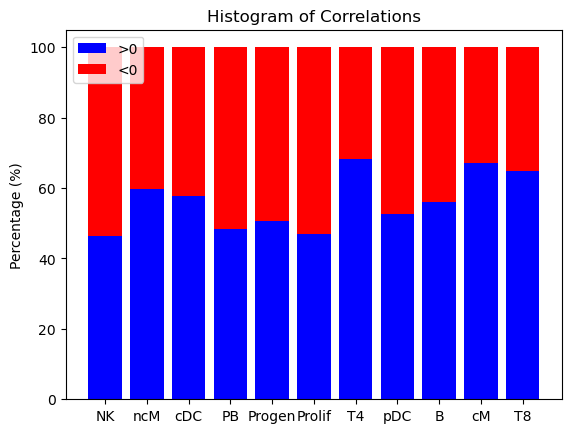

In [50]:
visualize_correlation(cell_type, pearson)

# GO & KEGG

In [48]:
# For GO & KEGG
positive = {}
negative = {}
# each gene 
for i in healthy.var.index:
    
#len(pearson["cM"]["corr"])

HES4
ISG15
TNFRSF18
TNFRSF4
MIB2
MMP23B
PLCH2
UTS2
ERRFI1
RBP7
CASZ1
RP4-635E18.8
FBXO2
AGTRAP
NPPA-AS1
PRDM2
RP3-467K16.4
EFHD2
RP11-108M9.6
CAMK2N1
CDA
EIF4G3
RP3-329E20.2
NBPF3
C1QA
C1QC
C1QB
RP5-1057J7.6
ID3
MDS2
CNR2
IFNLR1
RCAN3
RUNX3
STMN1
PAFAH2
ZNF683
FGR
IFI6
RNU11
EPB41
RP11-84A19.4
CCDC28B
FAM167B
ZBTB8A
RP11-244H3.4
RP4-728D4.2
CLSPN
CSF3R
MACF1
RP11-656D10.3
SLC2A1
PTCH2
PIK3R3
LINC00853
PDZK1IP1
TAL1
BEND5
ZCCHC11
SLC1A7
TTC22
MYSM1
PDE4B
IL12RB2
GADD45A
LRRC7
AK5
RP11-386I14.4
IFI44L
IFI44
RP5-887A10.1
RP11-486G15.2
SSX2IP
MCOLN2
ZNHIT6
ODF2L
GBP5
TGFBR3
EPHX4
KIAA1107
GFI1
RWDD3
RP11-305E17.6
RP4-549L20.3
AC093157.1
VAV3
VAV3-AS1
GSTM2
SLC16A4
RP11-96K19.2
RP5-1180E21.5
CHI3L2
RHOC
PTPN22
AP4B1-AS1
RP5-1073O3.7
DENND2C
TSPAN2
CD2
FAM46C
RP11-782C8.5
LINC00623
RP11-640M9.1
AL590452.1
RP11-326G21.1
NBPF10
ANKRD35
CD160
NBPF11
RP11-666A1.5
RP11-763B22.4
RP11-403I13.4
RP11-277L2.4
HIST2H2AA3
HIST2H2AB
OTUD7B
LINC00568
MCL1
CTSS
C1orf56
CDC42SE1
S100A9
S100A12
S100A8
S100A6

# KEGG pathyway

In [21]:
from bioservices import KEGG    #!pip install bioservices

In [22]:
result = healthy.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 使用bioservices进行KEGG富集分析
kegg = KEGG()

for group in groups:
    # 確保每個基因都被轉換為字符串
    gene_list = result['names'][group].tolist()
    print(f'Group {group}:')
    for gene in gene_list:
        # 使用get_pathway_by_gene方法來獲取這些基因參與的路徑
        pathways = kegg.get_pathway_by_gene(gene, 'hsa')    # hsa:Homo sapiens (human)
        print(pathways)

WARNING [bioservices.KEGG:130]:  The URL (http://rest.kegg.jp) provided cannot be reached.


Group 0:
{'hsa04970': 'Salivary secretion'}
{'hsa04657': 'IL-17 signaling pathway'}
{'hsa04657': 'IL-17 signaling pathway'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
{'hsa04380': 'Osteoclast differentiation', 'hsa04650': 'Natural killer cell mediated cytotoxicity'}
None
{'hsa04142': 'Lysosome', 'hsa04145': 'Phagosome', 'hsa04210': 'Apoptosis', 'hsa04612': 'Antigen processing and presentation', 'hsa05152': 'Tuberculosis'}
{'hsa01522': 'Endocrine resistance', 'hsa04010': 'MAPK signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04210': 'Apoptosis', 'hsa04380': 'Osteoclast differentiation', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04657': 'IL-17 signaling pathway', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa04662': 'B cell receptor signaling pathway', 'hsa04668': 'TNF signaling pathway', 'hsa04713': 'Circadian entrainmen

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
None
None
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
None
None
{'hsa04080': 'Neuroactive ligand-receptor interaction', 'hsa04979': 'Cholesterol metabolism', 'hsa05166': 'Human T-cell leukemia virus 1 infection'}
{'hsa00330': 'Arginine and proline metabolism', 'hsa01100': 'Metabolic pathways', 'hsa04216': 'Ferroptosis'}
None
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI signaling pathway', 'hsa05152': 'Tuberculosis', 'hsa05310': 'Asthma'}
{'hsa04142': 'Lysosome', 'hsa05170': 'Human immunodeficiency virus 1 infection'}
Group 1:
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa04060': 'Cytokine-cytokine receptor

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa00230': 'Purine metabolism', 'hsa01100': 'Metabolic pathways', 'hsa05222': 'Small cell lung cancer', 'hsa05223': 'Non-small cell lung cancer'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa05217': 'Basal cell carcinoma', 'hsa05221': 'Acute myeloid leukemia', 'hsa05224': 'Breast cancer', 'hsa05225': 'Hepatocellular carcinoma', 'hsa05226': 'Gastric cancer', 'hsa05412': 'Arrhythmogenic right ventricular cardiomyopathy'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hs

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
None
None
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04550': 'Signaling pathways regulating pluripotency of stem cells', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05165': 'Human papillomavirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal c

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa05144': 'Malaria'}
{'hsa04142': 'Lysosome'}
{'hsa01521': 'EGFR tyrosine kinase inhibitor resistance', 'hsa01522': 'Endocrine resistance', 'hsa01524': 'Platinum drug resistance', 'hsa04012': 'ErbB signaling pathway', 'hsa04014': 'Ras signaling pathway', 'hsa04015': 'Rap1 signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04066': 'HIF-1 signaling pathway', 'hsa04068': 'FoxO signaling pathway', 'hsa04070': 'Phosphatidylinositol signaling system', 'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04140': 'Autophagy - animal', 'hsa04150': 'mTOR signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04152': 'AMPK signaling pathway', 'hsa04210': 'Apoptosis', 'hsa04211': 'Longevity regulating pathway', 'hsa04213': 'Longevity regulating pathway - multiple species', 'hsa04218': 'Cellular senescence', 'hsa04360': 'Axon guidance', 'hsa04370': 'VEGF signaling pathway', 'hsa043

{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416': 'Viral myocarditis'}
{'hsa04151': 'PI3K-Akt signaling pathway'}
{'hsa040

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa05169': 'Epstein-Barr virus infection'}
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416': 'Viral myocarditis'}
{'hsa01524': 'Platinum drug resistance', 

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04142': 'Lysosome', 'hsa04210': 'Apoptosis'}
{'hsa04612': 'Antigen processing and presentation', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa05332': 'Graft-versus-host disease'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04623': 'Cytosolic DNA-sensing pathway', 'hsa05163': 'Human cytomegalovirus infection'}
{'hsa04210': 'Apoptosis', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04940': 'Type I diabetes mellitus', 'hsa05202': 'Transcriptional misregulation in cancer', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease'}
None
None
{'hsa04514': 'Cell adhesion molecules', 'hsa04670': 'Leukocyte transendothelial migration'}
{'hsa04640': 'Hematopoietic c

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
Group 5:
{'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05135': 'Yersinia infection', 'hsa05340': 'Primary immunodeficiency'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway'}
{'hsa04514': 'Cell adhesion 

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa0

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04550': 'Signaling pathways regulating pluripotency of stem cells', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05165': 'Human papillomavirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hs

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
Group 7:
{'hsa04970': 'Salivary secretion'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
{'hsa04380': 'Osteoclast differentiation', 'hsa04650': 'Natural killer cell mediated cytotoxicity'}
None
{'hsa04142': 'Lysosome', 'hsa04145': 'Phagosome', 'hsa04210': 'Apoptosis', 'hsa04612': 'Antigen processing and presentation', 'hsa05152': 'Tuberculosis'}
{'hsa04970': 'Salivary secretion'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
None
{'hsa00240': 'Pyrimidine metabolism', 'hsa00983': 'Drug metabolism - other enzymes', 'hsa01100': 'Metabolic pathways', 'hsa01232': 'Nucleotide metabolism', 'hsa05219': 'Bladder cancer'}
None
None
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI si

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04142': 'Lysosome', 'hsa04979': 'Cholesterol metabolism'}
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416':

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
{'hsa04010': 'MAPK signaling pathway', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa04145': 'Phagosome', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04936': 'Alcoholic liver disease', 'hsa05131': 'Shigellosis', 'hsa05132': 'Salmonella infection', 'hsa05133': 'Pertussis', 'hsa05134': 'Legionellosis', 'hsa05146': 'Amoebiasis', 'hsa05152': 'Tuberculosis', 'hsa05202': 'Transcriptional misregulation in cancer', 'hsa05221': 'Acute myeloid leukemia', 'hsa05417': 'Lipid and atherosclerosis'}
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI signaling pathway', 'hsa05152': 'Tuberculosis', 'hsa05310': 'Asthma'}
{'hsa00330': 'Arginine and proline metabolism', 'hsa01100': 'Metabolic pathways', 'hsa04216': 'Fer

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa01521': 'EGFR tyrosine kinase inhibitor resistance', 'hsa01522': 'Endocrine resistance', 'hsa01524': 'Platinum drug resistance', 'hsa04012': 'ErbB signaling pathway', 'hsa04014': 'Ras signaling pathway', 'hsa04015': 'Rap1 signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04066': 'HIF-1 signaling pathway', 'hsa04068': 'FoxO signaling pathway', 'hsa04070': 'Phosphatidylinositol signaling system', 'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04140': 'Autophagy - animal', 'hsa04150': 'mTOR signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04152': 'AMPK signaling pathway', 'hsa04210': 'Apoptosis', 'hsa04211': 'Longevity regulating pathway', 'hsa04213': 'Longevity regulating pathway - multiple species', 'hsa04218': 'Cellular senescence', 'hsa04360': 'Axon guidance', 'hsa04370': 'VEGF signaling pathway', 'hsa04380': 'Osteoclast differentiation', 'hsa04510': 'F

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa03015': 'mRNA surveillance pathway', 'hsa04071': 'Sphingolipid signaling pathway', 'hsa04110': 'Cell cycle', 'hsa04114': 'Oocyte meiosis', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04152': 'AMPK signaling pathway', 'hsa04261': 'Adrenergic signaling in cardiomyocytes', 'hsa04660': 'T cell receptor signaling pathway', 'hsa04728': 'Dopaminergic synapse', 'hsa05165': 'Human papillomavirus infection'}
None
{'hsa04514': 'Cell adhesion molecules', 'hsa04640': 'Hematopoietic cell lineage'}
{'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05135': 'Yersinia infection', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05135': 'Yersinia infection', 'hsa05340': 'Primary i

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
None
{'hsa05202': 'Transcriptional misregulation in cancer'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04550': 'Signaling pathways regulating pluripotency of stem cells', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alco

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa05217': 'Basal cell carcinoma', 'hsa05221': 'Acute myeloid le

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa00510': 'N-Glycan biosynthesis', 'hsa00513': 'Various types of N-glycan biosynthesis', 'hsa01100': 'Metabolic pathways'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
Group 11:
None
None
{'hsa04145': 'Phagosome', 'hsa04380': 'Osteoclast differentiation', 'hsa04613': 'Neutrophil extracellular trap formation', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04666': 'Fc gamma R-mediated phagocytosis', 'hsa05140': 'Leishmaniasis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05322': 'Systemic lupus erythematosus'}
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa04072': 'Phospholipase D signaling pathway', 'hsa04611': 'Platelet activation', 'hsa04625': 'C-type lectin receptor signaling pathway', 'hsa04650': 'Natural killer cell mediated cytotoxicity', 'hsa04664': 'Fc epsilon RI signaling pathway', 'hsa05152': 'Tuberculosis', 'hsa05310': 'Asthma'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptosis', 'hsa04978': 'Mineral absorption'}
{'hsa00330': 'Arginine and proline metabolism', 'hsa01100': 'Metabolic pathways', 'hsa04216': 'Ferroptosis'}
{'hsa04216': 'Ferroptosis', 'hsa04217': 'Necroptos

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04610': 'Complement and coagulation cascades', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa04380': 'Osteoclast differentiation', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05200': 'Pathways in cancer', 'hsa05202': 'Transcriptional misregulation in cancer', 'hsa05221': 'Acute myeloid leukemia'}
None
{'hsa04142': 'Lysosome', 'hsa04979': 'Cholesterol metabolism'}
{'hsa04142': 'Lysosome'}
None
None
None
{'hsa04066': 'HIF-1 signaling pathway'}
{'hsa04110': 'Cell cycle'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 12:
{'hsa04612': 'Antigen processing and presentation', 'hsa05152': 'Tuberculosis', 'hsa05168': 'Herpes simplex virus 1 infection'}
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allo

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04662': 'B cell receptor signaling pathway'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04014': 'Ras signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04371': 'Apelin signaling pathway', 'hsa04713': 'Circadian entrainment', 'hsa04723': 'Retrograde endocannabinoid signaling', 'hsa04724': 'Glutamatergic synapse', 'hsa04725': 'Cholinergic synapse', 'hsa04726': 'Serotonergic synapse', 'hsa04727': 'GABAergic synapse', 'hsa04728': 'Dopaminergic synapse', 'hsa04740': 'Olfactory transduction', 'hsa04926': 'Relaxin signaling pathway', 'hsa05032': 'Morphine addiction', 'hsa05034': 'Alcoholism', 'hsa05163': 'Human cytomegalovirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05200': 'Pathways in cancer'}
{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cel

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
Group 13:
None
None
None
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa04115': 'p53 signaling pathway', 'hsa05206': 'MicroRNAs in cancer'}
{'hsa03010': 'Ribosome', 'hsa05171': 'Coronavirus disease - COVID-19'}
{'hsa05206': 'MicroRNAs in cancer'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa05200': 'Pathways in cancer', 'hsa05221': 'Acute myeloid leukemia'}
None
{'hsa03040': 'Spliceosome', 'hsa04936': 'Alcoholic liver disease'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway'}
None
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junction', 'hsa04916': 'Melanogenesis', 'hsa04934': 'Cushing syndrome', 'hsa04936': 'Alcoholic liver disease', 'hsa05132': 'Salmonella infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05200': 'Pathways in cancer', 'hsa05210': 'Colorectal cancer', 'hsa05213': 'Endometrial cancer', 'hsa05215': 'Prostate cancer', 'hsa05216': 'Thyroid cancer', 'hsa05217': 'Basal cell carcinoma', 'hsa05221': 'Acute myeloid leukemia', 'hsa05224': 'Breast cancer', 'hsa05225': 'Hepatocellular carcinoma', 'hsa05226': 'Gastric cancer', 'hsa05412': 'Arrhythmogenic right ventricular cardiomyopathy'}
None
{'hsa04310': 'Wnt signaling pathway', 'hsa04390': 'Hippo signaling pathway', 'hsa04520': 'Adherens junc

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04068': 'FoxO signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa05200': 'Pathways in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04145': 'Phagosome', 'hsa04540': 'Gap junction', 'hsa04814': 'Motor proteins', 'hsa05010': 'Alzheimer disease', 'hsa05012': 'Parkinson disease', 'hsa05014': 'Amyotrophic lateral sclerosis', 'hsa05016': 'Huntington disease', 'hsa05020': 'Prion disease', 'hsa05022': 'Pathways of neurodegeneration - multiple diseases', 'hsa05130': 'Pathogenic Escherichia coli infection', 'hsa05132': 'Salmonella infection'}
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04014': 'Ras signaling pathway', 'hsa04062': 'Chemokine signaling pathway', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04371': 'Apelin signaling pathway', 'hsa04713': 'Circadian entrainment', 'hsa04723': 'Retrograde endocannabinoid signaling', 'hsa04724': 'Glutamatergic synapse', 'hsa04725': 'Cholinergic synapse', 'hsa04726': 'Serotonergic synapse', 'hsa04727': 'GABAergic synapse', 'hsa04728': 'Dopaminergic synapse', 'hsa04926': 'Relaxin signaling pathway', 'hsa05032': 'Morphine addiction', 'hsa05034': 'Alcoholism', 'hsa05163': 'Human cytomegalovirus infection', 'hsa05167': 'Kaposi sarcoma-associated herpesvirus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05200': 'Pathways in cancer'}
None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04022': 'cGMP-PKG signaling pathway', 'hsa04024': 'cAMP signaling pathway', 'hsa04270': 'Vascular smooth muscle contraction', 'hsa04360': 'Axon guidance', 'hsa04510': 'Focal adhesion', 'hsa04520': 'Adherens junction', 'hsa04530': 'Tight junction', 'hsa04670': 'Leukocyte transendothelial migration', 'hsa04810': 'Regulation of actin cytoskeleton', 'hsa04814': 'Motor proteins', 'hsa04921': 'Oxytocin signaling pathway', 'hsa05131': 'Shigellosis', 'hsa05132': 'Salmonella infection'

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa05323': 'Rheumatoid arthritis'}
None
{'hsa04060': 'Cytokine-cytokine receptor interaction'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04144': 'Endocytosis', 'hsa04151': 'PI3K-Akt signaling pathway', 'hsa04630': 'JAK-STAT signaling pathway', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05200': 'Pathways in cancer'}
None
{'hsa01524': 'Platinum drug resistance', 'hsa04064': 'NF-kappa B signaling pathway', 'hsa04120': 'Ubiquitin mediated proteolysis', 'hsa04210': 'Apoptosis', 'hsa04215': 'Apoptosis - multiple species', 'hsa04217': 'Necroptosis', 'hsa04390': 'Hippo signaling pathway', 'hsa04510': 'Focal adhesion', 'hsa04621': '

{'hsa04145': 'Phagosome', 'hsa04514': 'Cell adhesion molecules', 'hsa04612': 'Antigen processing and presentation', 'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04672': 'Intestinal immune network for IgA production', 'hsa04940': 'Type I diabetes mellitus', 'hsa05140': 'Leishmaniasis', 'hsa05145': 'Toxoplasmosis', 'hsa05150': 'Staphylococcus aureus infection', 'hsa05152': 'Tuberculosis', 'hsa05164': 'Influenza A', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05168': 'Herpes simplex virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05310': 'Asthma', 'hsa05320': 'Autoimmune thyroid disease', 'hsa05321': 'Inflammatory bowel disease', 'hsa05322': 'Systemic lupus erythematosus', 'hsa05323': 'Rheumatoid arthritis', 'hsa05330': 'Allograft rejection', 'hsa05332': 'Graft-versus-host disease', 'hsa05416': 'Viral myocarditis'}
{'hsa04071': 'Sphingolipid signaling pathway', 'hsa

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04080': 'Neuroactive ligand-receptor interaction'}
None
{'hsa04060': 'Cytokine-cytokine receptor interaction'}
{'hsa04145': 'Phagosome', 'hsa04210': 'Apoptosis', 'hsa04530': 'Tight junction', 'hsa04540': 'Gap junction', 'hsa04814': 'Motor proteins', 'hsa05010': 'Alzheimer disease', 'hsa05012': 'Parkinson disease', 'hsa05014': 'Amyotrophic lateral sclerosis', 'hsa05016': 'Huntington disease', 'hsa05020': 'Prion disease', 'hsa05022': 'Pathways of neurodegeneration - multiple diseases', 'hsa05130': 'Pathogenic Escherichia coli infection', 'hsa05132': 'Salmonella infection'}
{'hsa03030': 'DNA replication', 'hsa03410': 'Base excision repair', 'hsa03420': 'Nucleotide excision repair', 'hsa03430': 'Mismatch repair', 'hsa04110': 'Cell cycle', 'hsa04530': 'Tight junction', 'hsa05161': 'Hepatitis B'}
None
{'hsa04514': 'Cell adhesion molecules', 'hsa04670': 'Leukocyte transendothelial migration'}
{'hsa04110': 'Cell cycle', 'hsa04114': 'Oocyte meiosis', 'hsa05166': 'Human T-cell leu

WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Not Found
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
None
{'hsa04640': 'Hematopoietic cell lineage', 'hsa04658': 'Th1 and Th2 cell differentiation', 'hsa04659': 'Th17 cell differentiation', 'hsa04660': 'T cell receptor signaling pathway', 'hsa05142': 'Chagas disease', 'hsa05162': 'Measles', 'hsa05166': 'Human T-cell leukemia virus 1 infection', 'hsa05169': 'Epstein-Barr virus infection', 'hsa05170': 'Human immunodeficiency virus 1 infection', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer', 'hsa05340': 'Primary immunodeficiency'}
{'hsa04060': 'Cytokine-cytokine receptor interaction', 'hsa04061': 'Viral protein interaction with cytokine and cytokine receptor', 'hsa04062': 'Chemokine signaling pathway', 'hsa04620': 'Toll-like receptor signaling pathway', 'hsa04621': 'NOD-like receptor signaling pathway', 'hsa04623': 'Cytosolic DNA-sensing pathway', 'hsa04668': 'TNF signaling pathway', 'hsa05020': 'Prion disease', 'hsa05120': 'Epithelial cell signaling in Helicobacter pylori infection', 'hsa05131': 'Shigellosis', '

WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 20:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 21:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 22:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None
Group 23:


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


WARNING [bioservices.KEGG:596]:  status is not ok with Forbidden
WARNING [bioservices.KEGG:1181]:  Could not parse the entry correctly.


None


In [23]:
healthy

AnnData object with n_obs × n_vars = 486418 × 1999
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'cg_cov_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

# ANOVA